<div>
<img src="https://upload.wikimedia.org/wikipedia/sco/thumb/d/d1/University_College_London_logo.svg/1280px-University_College_London_logo.svg.png" width="400px" align = "left"/>
</div>

# Feature Engineering for Detection of Parkinson Disease Severity with Motion Sensor Arrays
## Frequency Domain Data Analysis
`
Last Modified: 30th Jul 2020
Author: Ken Yew Piong
Department: MEng Electronic Engineering with Computer Science
`
### Description:
#### This is a standalone tool for frequency domain data analysis with the following features: 
```tex
1. Data Pre-processing: High Pass Filter to remove gravity component DC offset of accelerometer sensor data
2. Data Pre-processing: Fast Fourier Transform to transform time series sensor data into discrete frequency components
3. Feature Engineering: Extraction of insightful frequency domain features of PD gestures using statistical tools (e.g.: mean, std, iqr, skewness, kurtosis) 
4. Data Visualisation: Visualisation of frequency domain features against different levels of UPDRS rating PD severity
```

---
## 1.0 Library Import
### Prerequisites: 
```tex
Please install the Python libraries listed below before using this tool using the pip command:
1. os, mah, import_ipynb, mpld3
2. numpy
3. pandas
4. matplotlib
5. seaborn
6. scipy
Prerequisite functions will need to be imported from the util.ipynb file saved within the same directory of this tool. 
```

In [1]:
import os, math, import_ipynb, mpld3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from scipy.stats import iqr, skew, kurtosis, variation, pearsonr
from scipy import fftpack
from scipy.fftpack import fft
from scipy import signal
from util import *

importing Jupyter notebook from util.ipynb


In [2]:
# Enabling matplotlib magic function to save plots within notebook
%matplotlib inline
# Enabling mpld3 function for enhanced matplotlib visualisation tools (e.g.: zoom, pan)
mpld3.enable_notebook()

---
### 1.1 Global Parameters for Plot Customisation
Customize the default matplotlib axes and linestyle that will be applied to all plots within this notebook.

In [3]:
# ========================================================
# Global Configuration Dictionary for Plot Customisation
# ========================================================
# use pylab.rcParams.update(params) to update settings
params = {'lines.linewidth' : 1,
          'legend.fontsize': 24,
          'legend.loc': 'best',
          'figure.figsize': (17, 10),
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize': 24,
         'ytick.labelsize': 24,
         'font.weight': 'bold',
         'axes.labelweight': 'bold',
         'axes.titleweight': 'bold'}

# ====================================
# Update plot customisation parameters
# ====================================
pylab.rcParams.update(params)

--- 
## 2.0 Data Extraction
Change the variable _**working_directory**_ below with the path to your patient data in __string__ format

In [4]:
# ========================================================
# 1. Specify the directory path to the dataset of interest
# ========================================================
working_directory = '/Users/kenyew/Documents/Git/Parkinson-Disease-Repository-local/Patient003'
print(working_directory)

/Users/kenyew/Documents/Git/Parkinson-Disease-Repository-local/Patient003


### 2.1 Database Creation
#### Pre-requisites: 
* _**patient003_timestamps**_ is a dictionary with the keys as the name of the PD gesture and the values as the 3 pairs of timestamps for each PD session. <br>
* Use this cell only if you have data containing 3 PD sessions within a PD trial that needs to be automatically truncated and stored in a dictionary database.

In [5]:
# Dictionary storing the manual truncation timestamps for each CSV file
df_dict = {}
patient003_timestamps = {'ftap-lvl0-forearm': [18.8, 31.0, 47.0, 58.4, 72.8, 84.3],
                          'ftap-lvl1-forearm': [19.6, 32.0, 47.2, 59.5, 73.9, 85.8],
                          'ftap-lvl2-forearm': [16.9, 30.0, 44.2, 56.5, 72.0, 84.4],
                          'ftap-lvl3-forearm': [19.9, 32.5, 47.6, 61.0, 77.0, 93.0],
                          'ftap-lvl4-forearm': [16.8, 30.0, 45.0, 57.0, 72.5, 86.2],
                          'ftap-lvl0-wrist': [17.4, 29.5, 44.5, 56.5, 71.8, 83.5],
                          'ftap-lvl1-wrist': [18.5, 31.5, 46.5, 58.5, 73.2, 87.0],
                          'ftap-lvl2-wrist': [20.0, 36.0, 53.0, 65.5, 82.0, 97.0],
                          'ftap-lvl3-wrist': [20.2, 33.0, 47.5, 61.0, 75.5, 88.2],
                          'ftap-lvl4-wrist': [19.5, 33.0, 48.0, 60.0, 74.5, 89.5],
                          'hmove-lvl0-forearm': [19.5, 28.0, 42.8, 49.5, 64.0, 72.0],
                          'hmove-lvl1-forearm': [18.0, 26.0, 43.4, 52.0, 68.0, 78.2],
                          'hmove-lvl2-forearm': [18.4, 31.6, 46.6, 59.5, 74.8, 90.8],
                          'hmove-lvl3-forearm': [17.6, 36.0, 51.2, 62.5, 78.0, 95.0],
                          'hmove-lvl4-forearm': [20.2, 40.5, 55.9, 74.0, 88.6, 111.5],
                          'hmove-lvl0-wrist': [19.0, 25.4, 40.1, 46.5, 60.8, 68.8],
                          'hmove-lvl1-wrist': [15.9, 25.8, 41.7, 50.0, 65.0, 74.9],
                          'hmove-lvl2-wrist': [17.0, 29.0, 44.5, 60.0, 74.0, 90.0],
                          'hmove-lvl3-wrist': [20.0, 35.0, 50.2, 68.2, 82.8, 104.0],
                          'hmove-lvl4-wrist': [18.8, 47.5, 62.5, 88.5, 104.0, 126.0],
                          'tota-lvl0-calf&heel': [20.0, 24.5, 39.6, 44.2, 59.0, 63.8],
                          'tota-lvl1-calf&heel': [23.5, 31.5, 47.0, 54.5, 70.0, 83.0],
                          'tota-lvl2-calf&heel': [16.5, 27.2, 43.0, 53.0, 68.0, 75.8],
                          'tota-lvl3-calf&heel': [19.6, 29.0, 45.0, 61.5, 79.5, 91.0],
                          'tota-lvl4-calf&heel': [19.0, 41.0, 57.5, 73.5, 88.5, 103.0],
                          'tota-lvl0-heel': [19.5, 24.2, 39.8, 44.8, 60.4, 65.0],
                          'tota-lvl1-heel': [24.0, 33.5, 49.0, 58.2, 73.6, 82.2],
                          'tota-lvl2-heel': [17.1, 27.4, 42.9, 54.2, 69.3, 81.8],
                          'tota-lvl3-heel': [17.6, 32.5, 47.8, 64.0, 84.5, 98.0],
                          'tota-lvl4-heel': [19.4, 33.4, 48.8, 60.0, 75.1, 88.5]
}

# ===============================================================================
# 2. Algorithm to automatically apply the truncation timestamps to each CSV file 
#    and store the resulting df in a dictionary database called df_dict
# ===============================================================================
for dirpath, dirnames, filenames in os.walk(working_directory): 
    # For loop through each CSV file within directory
    for filename in filenames: 
        path = os.path.join(dirpath, filename)
        
        # For-if loop to only loop through CSV files that contain the key from patient003_timestamps dictionary
        for gesture in list(patient003_timestamps.keys()): 
            if gesture in filename: 
                
                # Read the entire raw dataframe from CSV file
                df = pd.read_csv(path)
                
                # Extract timestamps from patient003_timestamps dictionary
                start1 = patient003_timestamps[gesture][0]
                end1 = patient003_timestamps[gesture][1]
                start2 = patient003_timestamps[gesture][2]
                end2 = patient003_timestamps[gesture][3]
                start3 = patient003_timestamps[gesture][4] 
                end3 = patient003_timestamps[gesture][5] 
                
                # Manually truncate dataframes into 3 separate trials
                df_trial_1 = df[(df['elapsed (s)'] >= start1) & (df['elapsed (s)'] <= end1)] # truncate the data
                df_trial_2 = df[(df['elapsed (s)'] >= start2) & (df['elapsed (s)'] <= end2)] # truncate the data
                df_trial_3 = df[(df['elapsed (s)'] >= start3) & (df['elapsed (s)'] <= end3)] # truncate the data
                
                # Append new key-value pairs into the database for each truncated dataframe (OUTPUT: df_dict)
                if 'Accelerometer' in filename: 
                    df_dict[gesture+'-accel-trial1'] = pd.DataFrame(df_trial_1)
                    df_dict[gesture+'-accel-trial2'] = pd.DataFrame(df_trial_2)
                    df_dict[gesture+'-accel-trial3'] = pd.DataFrame(df_trial_3)
                elif 'Gyroscope' in filename:
                    df_dict[gesture+'-gyro-trial1'] = pd.DataFrame(df_trial_1)
                    df_dict[gesture+'-gyro-trial2'] = pd.DataFrame(df_trial_2)
                    df_dict[gesture+'-gyro-trial3'] = pd.DataFrame(df_trial_3)

### 2.2 Visualise DataFrame
* All your patient data will have been extracted and stored in a database dictionary called df_dict. <br>
* To view your data, call the key of the df_dict dictionary with the key being the name of the PD gesture of interest (e.g.: 'tota-lvl0-heel-gyro-trial2')

In [6]:
# View your DataFrames by calling the key of the df_dict dictionary
df_dict['tota-lvl0-heel-gyro-trial2']

,epoch (ms),time (-00:00),elapsed (s),x-axis (deg/s),y-axis (deg/s),z-axis (deg/s)
2003,1584015941550,2020-03-12T12:25:41.550,39.808,0.831,0.206,-0.236
2004,1584015941569,2020-03-12T12:25:41.569,39.827,0.869,0.175,-0.358
2005,1584015941590,2020-03-12T12:25:41.590,39.848,0.869,0.114,-0.389
2006,1584015941610,2020-03-12T12:25:41.610,39.868,0.816,0.069,-0.488
2007,1584015941629,2020-03-12T12:25:41.629,39.887,0.701,0.152,-0.450
...,...,...,...,...,...,...
2250,1584015946459,2020-03-12T12:25:46.459,44.717,-0.160,0.427,0.526
2251,1584015946480,2020-03-12T12:25:46.480,44.738,-0.412,1.212,0.328
2252,1584015946499,2020-03-12T12:25:46.499,44.757,-0.678,1.601,-0.259
2253,1584015946519,2020-03-12T12:25:46.519,44.777,-0.526,1.410,-0.282


---
## 3.0 Data Pre-processing
Run this cell to automatically create a dictionary database containing the following pre-processed data: <br>
#### Pre-requisite: 
* df_dict: database dictionary of extracted data

```tex
1. time_df_dict: Filtered time series data 
2. hpf_df_dict: Filtered time series data (same data as 1) 
3. raw_fft_df_dict: Unfiltered frequency domain data
4. fft_df_dict: Filtered frequency domain data
5. psd_df_dict: Power spectral density data
6. all_df_dict: Master database of all the pre-processed data above
```

In [7]:
# ====================
# Input Parameters
# ====================
fs = 50 # 50 Hz is the hard-wired sampling frequency of the MBient sensor
highcut = 1 # 1 Hz, removing only the starting DC offset for accelerometer data
order = 5 # polynomial order to the 5th power should have sufficient performance for filter

# ====================
# Data Pre-processing
# ====================
# Process all the raw truncated dataframes using the pre-processing functions above and storing the 
# processed dataframes in dictionaries

# =============================================
# 0. Filtered Time Series (stored in: time_df_dict)
# =============================================
time_df_dict = {}
for key, value in df_dict.items(): # process all the truncated dataframes from the dictionary database
    if 'accel' in key: # apply HPF to accelerometer data only as DC offsets only occur in accelerometers
        time_df_dict[key+'-time'] = process_HPF(value, highcut, fs, order) # append '-hpf' to key
    else:
        time_df_dict[key+'-time'] = value
        
# =============================================
# 1. High Pass Filter (stored in: hpf_df_dict)
# =============================================
hpf_df_dict = {} 
for key, value in df_dict.items(): # process all the truncated dataframes from the dictionary database
    if 'accel' in key: # apply HPF to accelerometer data only as DC offsets only occur in accelerometers
        hpf_df_dict[key+'-hpf'] = process_HPF(value, highcut, fs, order) # append '-hpf' to key
    else:
        hpf_df_dict[key+'-hpf'] = value

# =============================================
# 2. FFT without HP Filtering (stored in: raw_fft_df_dict)
# =============================================
raw_fft_df_dict = {}
for key, value in df_dict.items(): # process all the truncated dataframes from the dictionary database
    raw_fft_df_dict[key+'-fft'] = process_FFT(value, fs)

# =============================================
# 3. FFT (stored in: fft_df_dict)
# =============================================
fft_df_dict = {}
for key, value in hpf_df_dict.items(): # process all the truncated dataframes from the dictionary database
    fft_df_dict[key+'-fft'] = process_FFT(value, fs)

# =============================================
# 4. PSD (stored in: psd_df_dict)
# =============================================
psd_df_dict = {}
for key, value in hpf_df_dict.items(): # process all the truncated dataframes from the dictionary database
    psd_df_dict[key+'-psd'] = process_PSD(value, fs)

# =============================================
# Database Creation (all of the processed dataframes above are stored in one unified dictionary called 'database')
# =============================================
all_df_dict = [df_dict, time_df_dict, hpf_df_dict, raw_fft_df_dict, fft_df_dict, psd_df_dict]
database = {}
for df in all_df_dict:
    database.update(df)

/Users/kenyew/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 236, using nperseg = 236
  .format(nperseg, input_length))
/Users/kenyew/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 252, using nperseg = 252
  .format(nperseg, input_length))
/Users/kenyew/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 231, using nperseg = 231
  .format(nperseg, input_length))
/Users/kenyew/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 226, using nperseg = 226
  .format(nperseg, input_length))
/Users/kenyew/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 242, using nperseg = 242
  .format(nperseg, input_leng

---
## 4.0 Data Visualization

### 4.1 Lists for multiple plots
This is a pre-requisite cell that needs to be run to create a list of dictionaries required for data visualisation later.

In [8]:
# ===========================================================================================
# Algorithm to create a list of strings with the same gesture but different severity levels
# ===========================================================================================
def get_list(database, search_array):
    rst = []
    for lst in [x.split('-') for x in list(database.keys())]:
        if all(elem in lst for elem in search_array):
            joined = '-'.join(lst)
            rst.append(joined)
    return sorted(rst)

# =================================================================
# Creating a list of terms to search when using get_list function
# =================================================================
lst = []
for key in list(database.keys()):
    search_array = key.split('-')
    search_array.pop(1) # Removing lvl0 term from the search array
    lst.append(search_array)

# =================================================================
# Creating a dictionary of lists sorted by levels of severity
# =================================================================
lst_dict = {}
for i in lst:     
    lst_dict['-'.join(i)] = get_list(database, i) 

---
### 4.2 Individual Plots
* Visualise your PD data by changing the _**data_name**_ variable below to the PD gesture name of interest. 
* The list of PD gesture names to choose from can be found by printing _**database.keys()**_

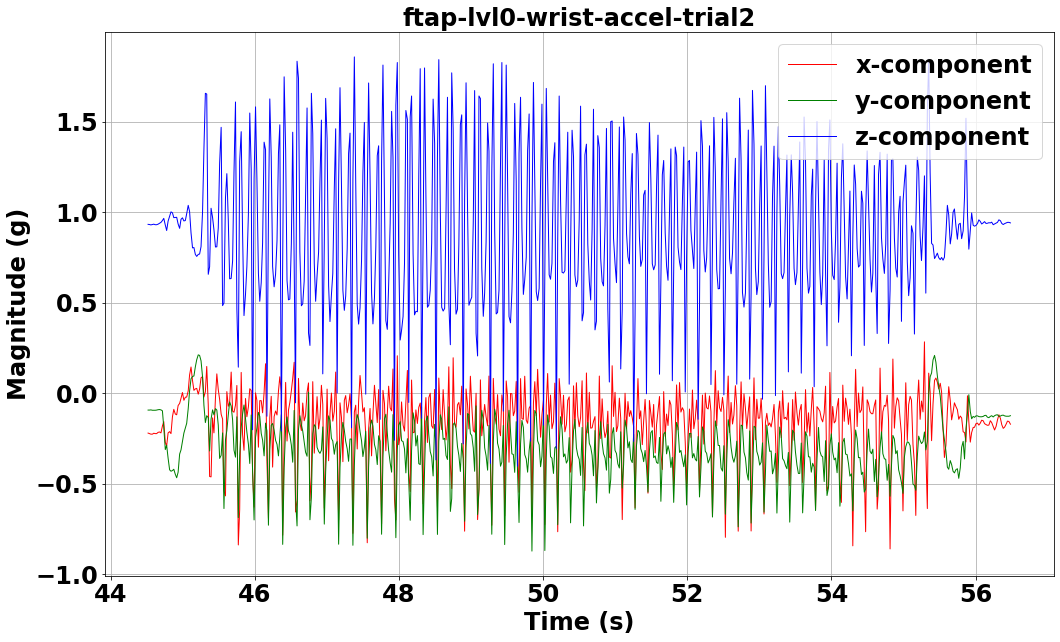

In [9]:
# ====================
# Input Parameters
# ====================
data_name = 'ftap-lvl0-wrist-accel-trial2' 
savefig = False # Change to True to automatically save a PNG figure of the plot

plot_df = database[data_name]
visualize(data_name, plot_df, savefig)

---
### 4.3 Multiple Plots by Level of PD Severity
* Visualise your PD data for all 5 levels of PD severity by changing the key name of the _**data_name_lst**_ variable below to the PD gesture of interest. 
* The list of PD gesture to choose from can be found by printing _**database.keys()**_


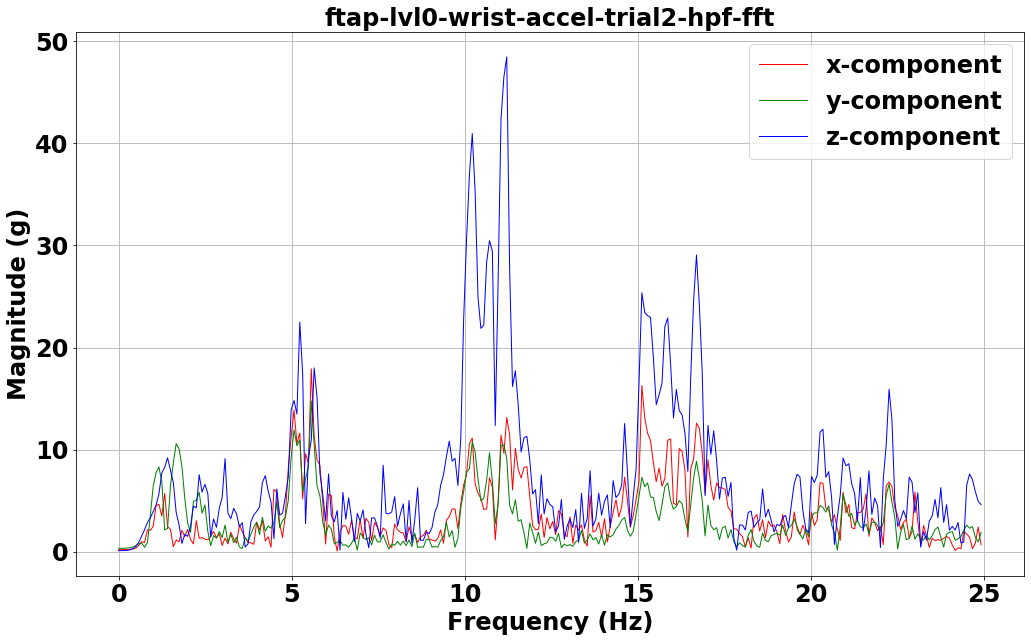

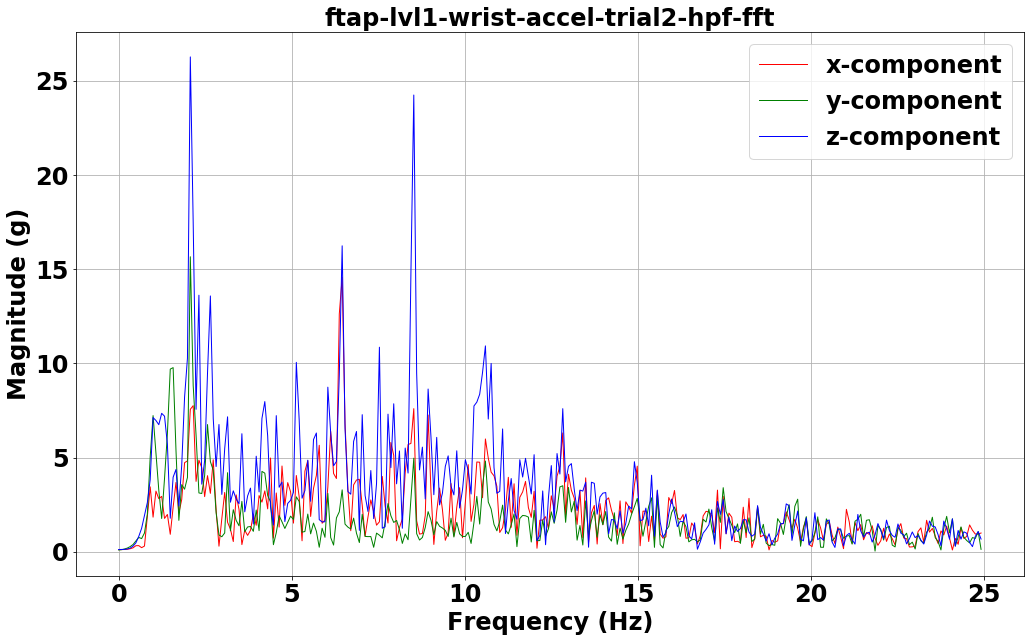

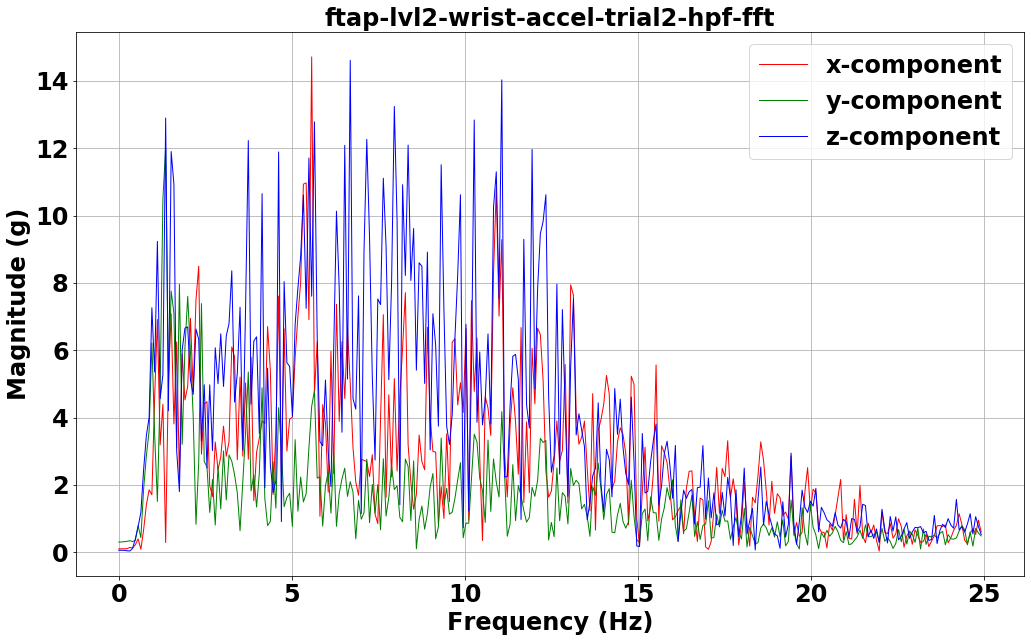

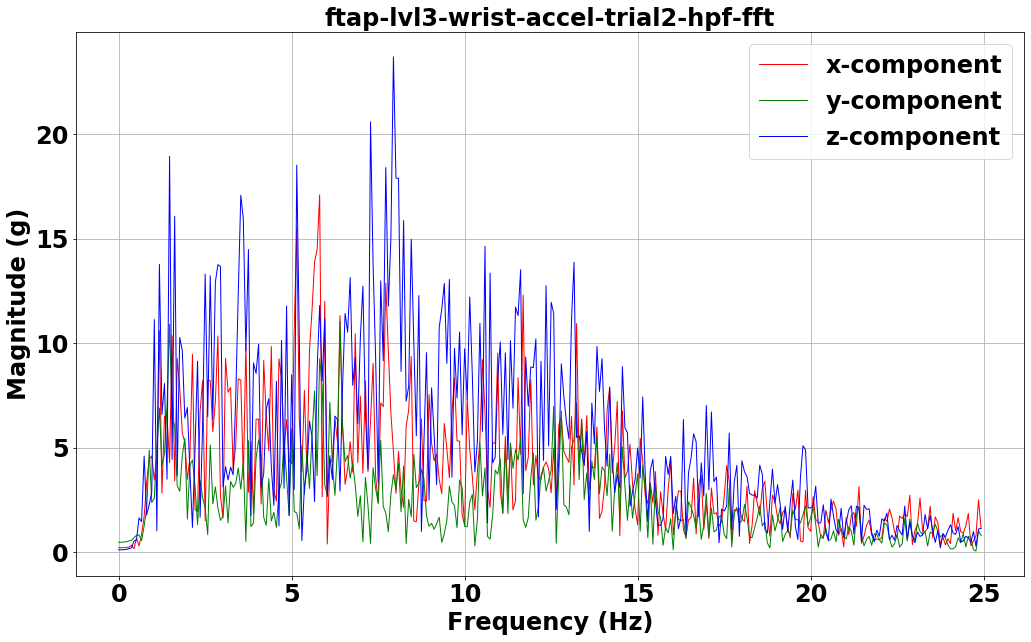

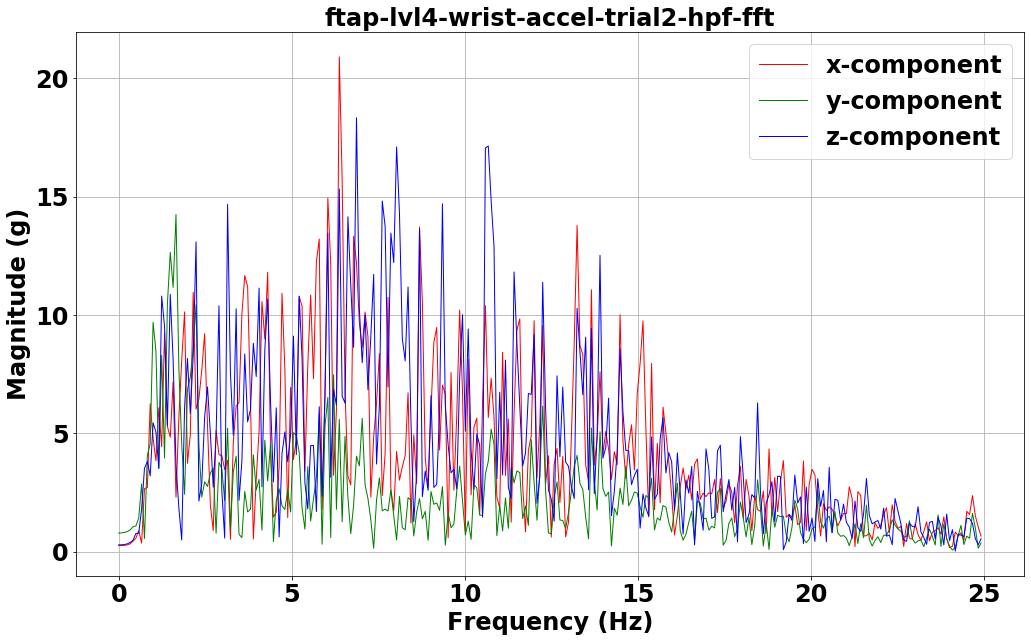

In [10]:
# ====================
# Input Parameters
# ====================
data_name_lst = lst_dict['ftap-wrist-accel-trial2-hpf-fft'] # Refer to 4.2 Lists of Multiple Plots for options of multiple plots
savefig = False 

for data_name in data_name_lst:
    plot_df = database[data_name]
    visualize(data_name, plot_df, savefig)

---
## 5.0 Feature Engineering in the Frequency Domain
This section focuses on extracting the following features from pre-processed frequency domain data:
```python 
1. Mean of Amplitude
2. Standard deviation of Amplitude
3. Median of Amplitude
4. Interquartile Range of Amplitude
5. Coefficient of Variation of Amplitude
6. Skewness of Amplitude Distribution
7. Kurtosis of Amplitude Distribution
```

---
### 5.1 Summary of All Features
* Visualise the frequency domain features extracted from your PD data by changing the name of the _**filename**_ variable below to the PD gesture of interest. 
* The list of PD gesture to choose from can be found by printing _**lst_dict.keys()**_

In [11]:
# =================
# Input parameter
# =================
filename = 'hmove-lvl0-wrist-accel-trial2-hpf-fft'

# =============================================
# Compute and display summary of all features
# =============================================
fs = 50
df = database[filename]
tabulated_stats_df = process_all_metrics(df, filename)
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

print(filename)
tabulated_stats_df

hmove-lvl0-wrist-accel-trial2-hpf-fft


/Users/kenyew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,metric name,metric description,x-axis (g),y-axis (g),z-axis (g),resultant (g)
0,mean,Computed average value of amplitudes in the frequency domain,2.026210,1.544214,3.229885,4.113670
1,std,Computed standard deviation of amplitudes in the frequency domain,1.622778,1.418931,3.505335,4.115112
2,median,50th percentile value of the amplitudes in the frequency domain,1.512429,1.168802,2.150664,2.877307
3,iqr,Interquartile range of the amplitudes in the frequency domain,1.416848,1.299690,2.783928,3.383328
4,min,Absolute minimum value of amplitude in the frequency domain,0.015438,0.067516,0.188335,0.200666
5,max,Absolute maximum value of amplitude in the frequency domain,9.545477,8.670526,23.915582,27.170742
6,cov,Coefficient of variation of amplitudes in the frequency domain,0.798402,0.916011,1.081906,1.626974
7,skewness,Sample skewness of the amplitude distribution in the frequency domain,1.963473,2.295308,3.012999,4.266360
8,kurtosis,Sample kurtosis of the amplitude distribution in the frequency domain,5.031307,6.698967,12.018992,14.650815


---
### 5.1 Visualising the Statistical Trends of Frequency Domain Features Extracted
This section focuses on plotting the statistical trends graph of Frequency Domain Feature Values versus Level of PD Severity
* Visualise the statistical trends of features extracted from your PD data by changing the key name of the _**lst1**_, _**lst2**_ and _**lst3**_ variables below to the PD gesture of interest. 
* You must copy and paste the same PD gesture name with different trial numbers for each variable. For example: 
```python 
lst1 = lst_dict['hmove-wrist-accel-trial1-hpf-fft']
lst2 = lst_dict['hmove-wrist-accel-trial2-hpf-fft']
lst3 = lst_dict['hmove-wrist-accel-trial3-hpf-fft']
```
* The list of PD gesture to choose from can be found by printing _**database.keys()**_

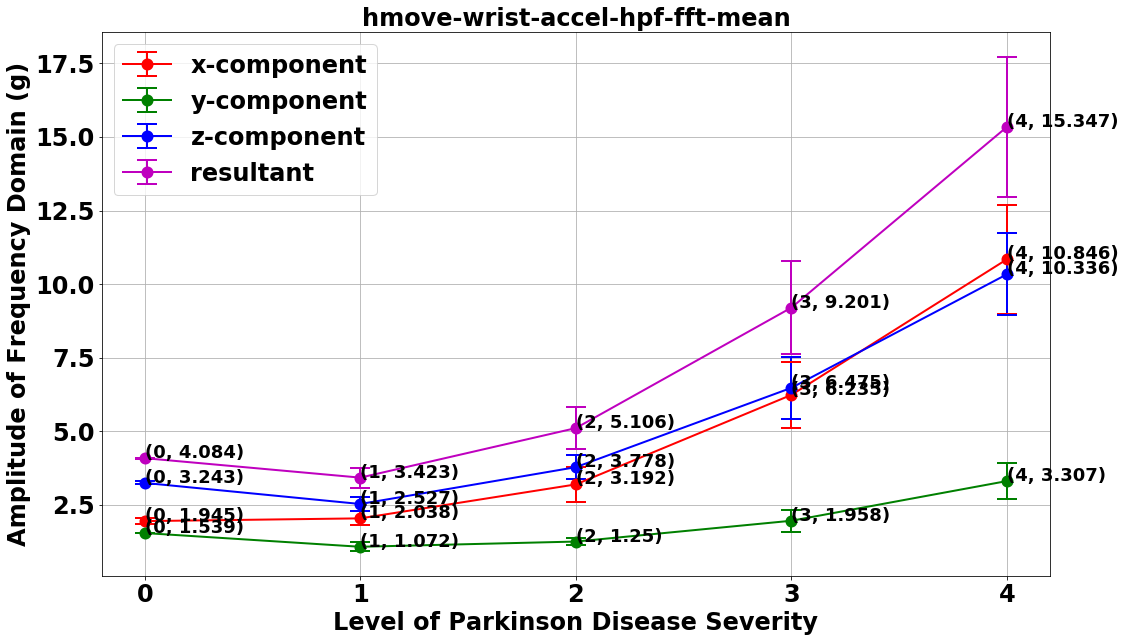

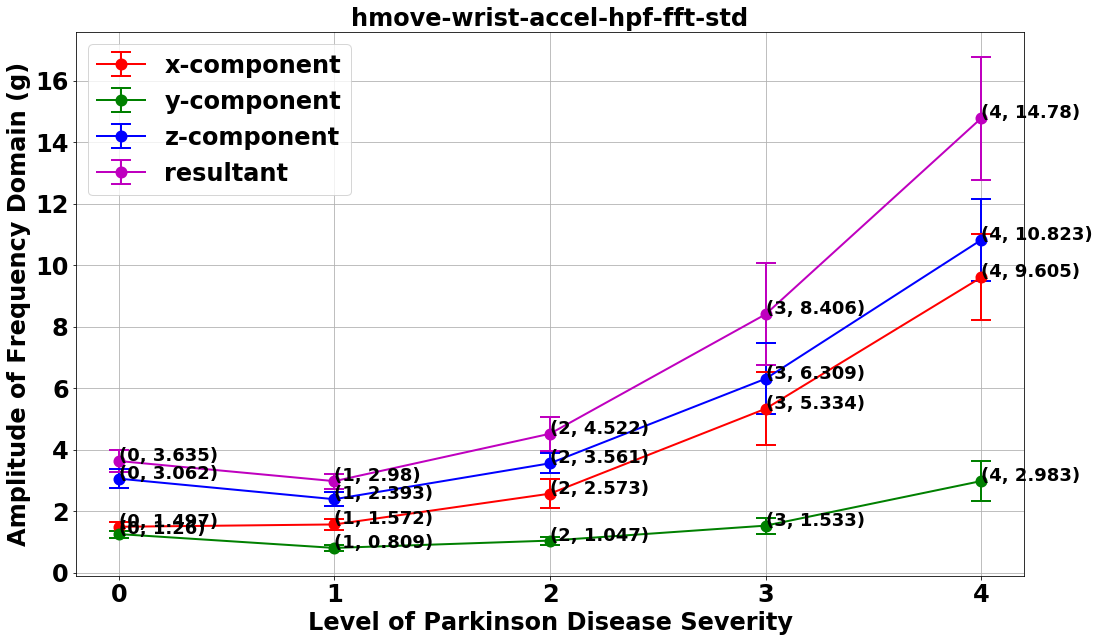

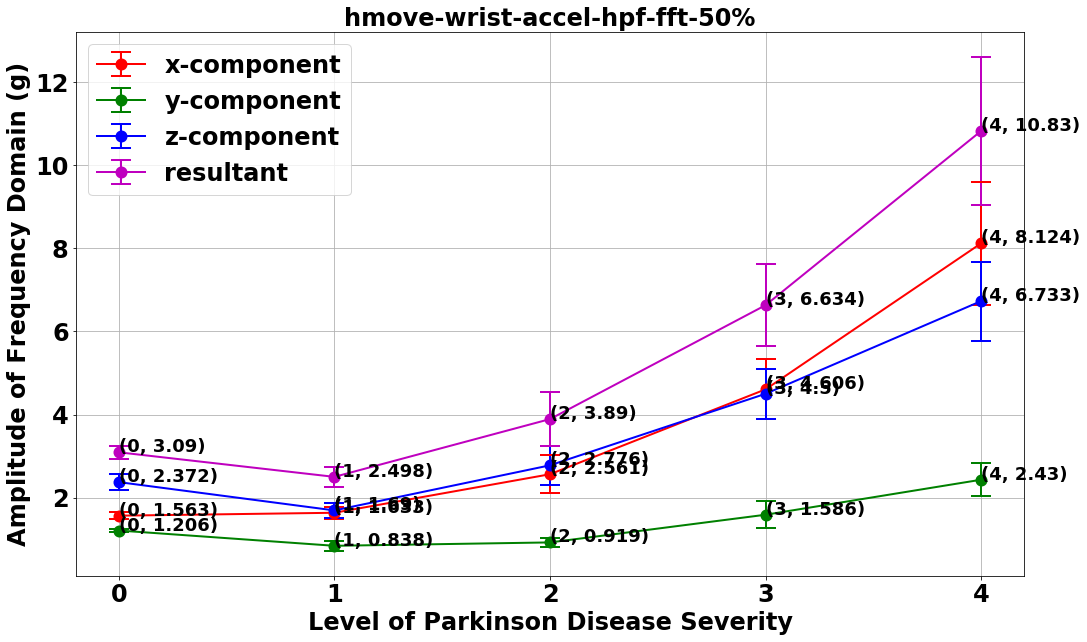

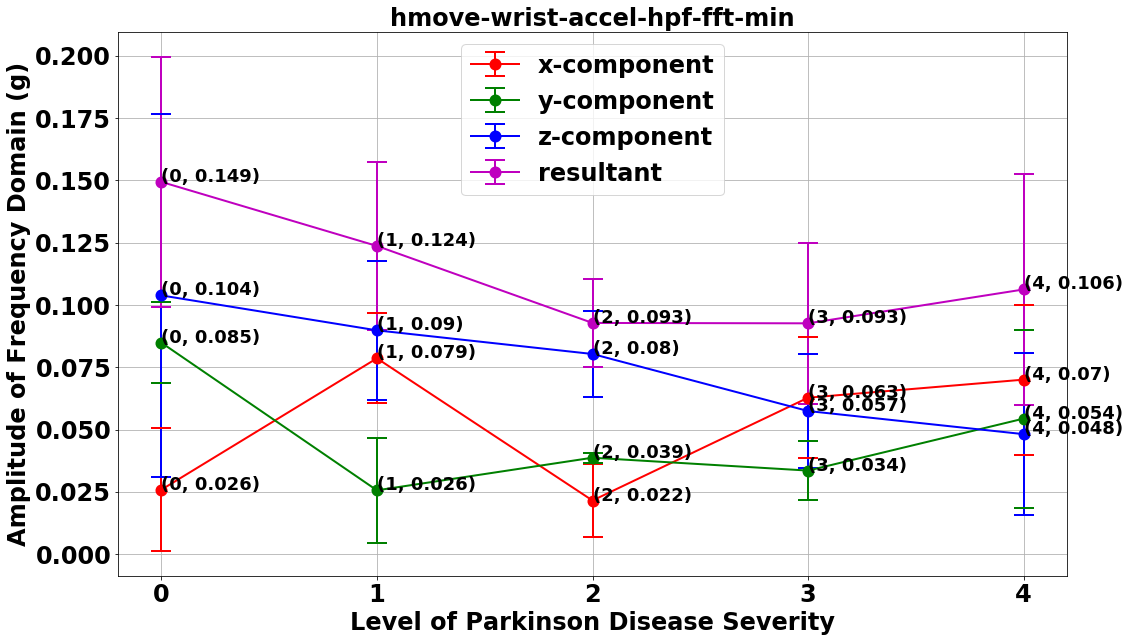

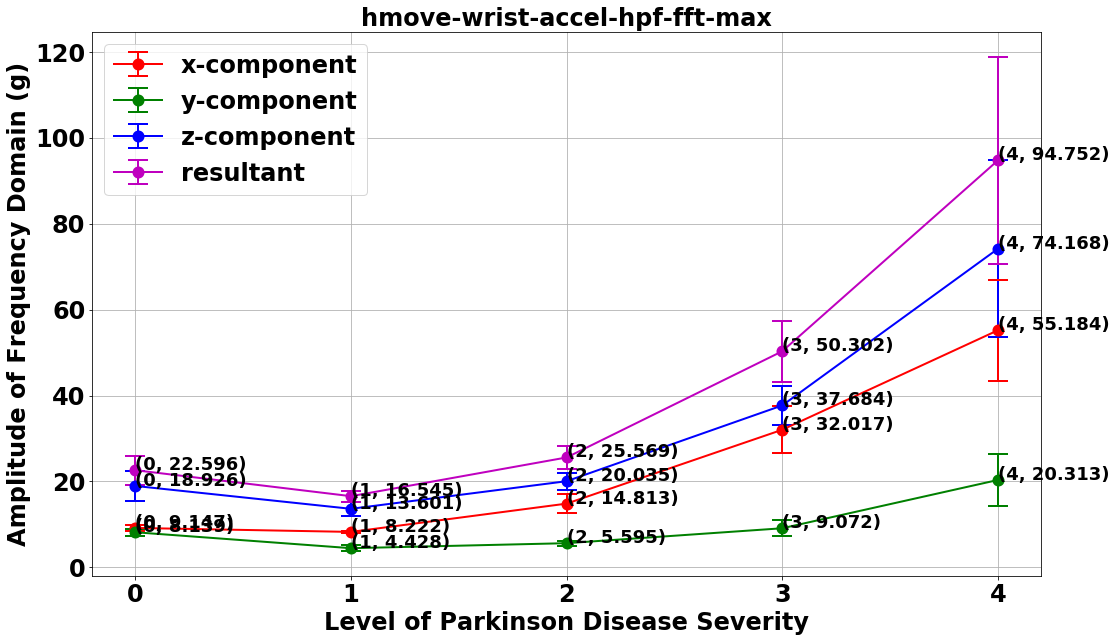

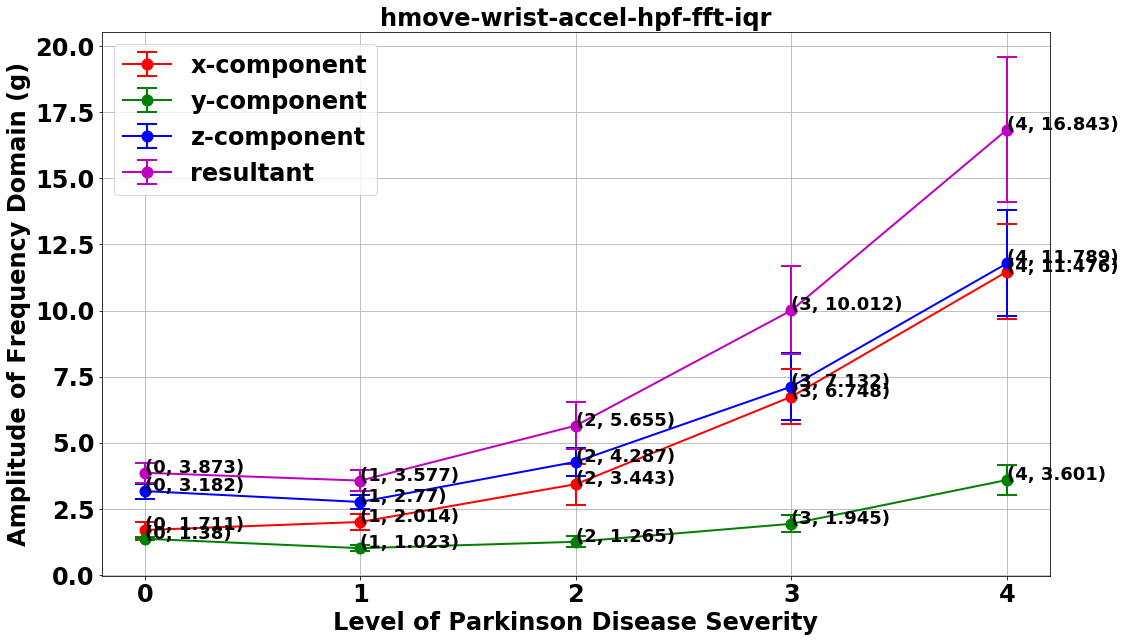

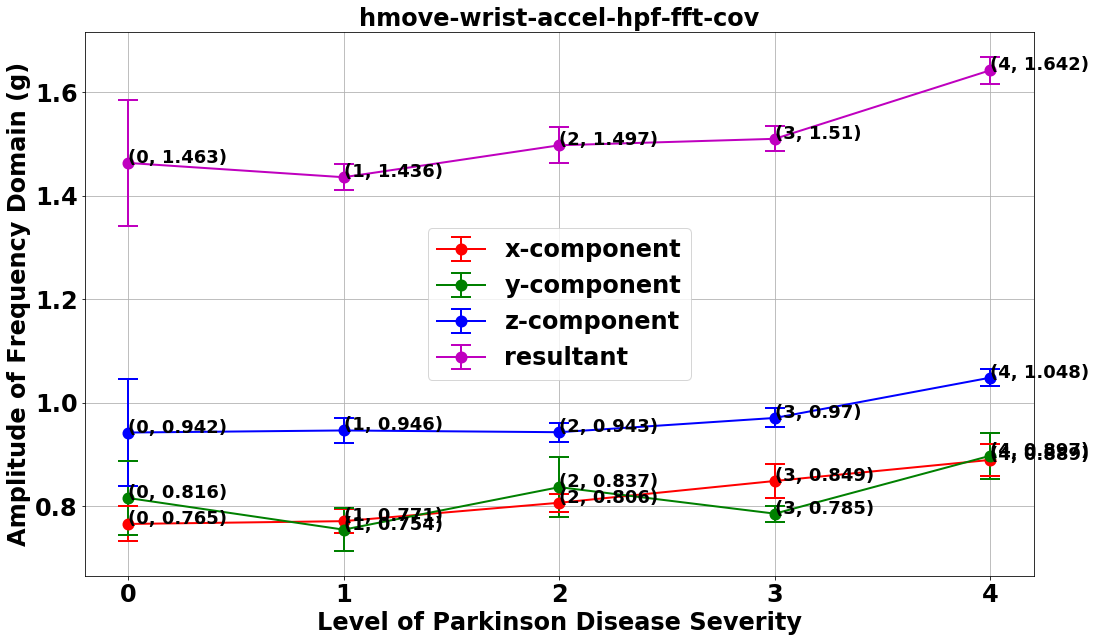

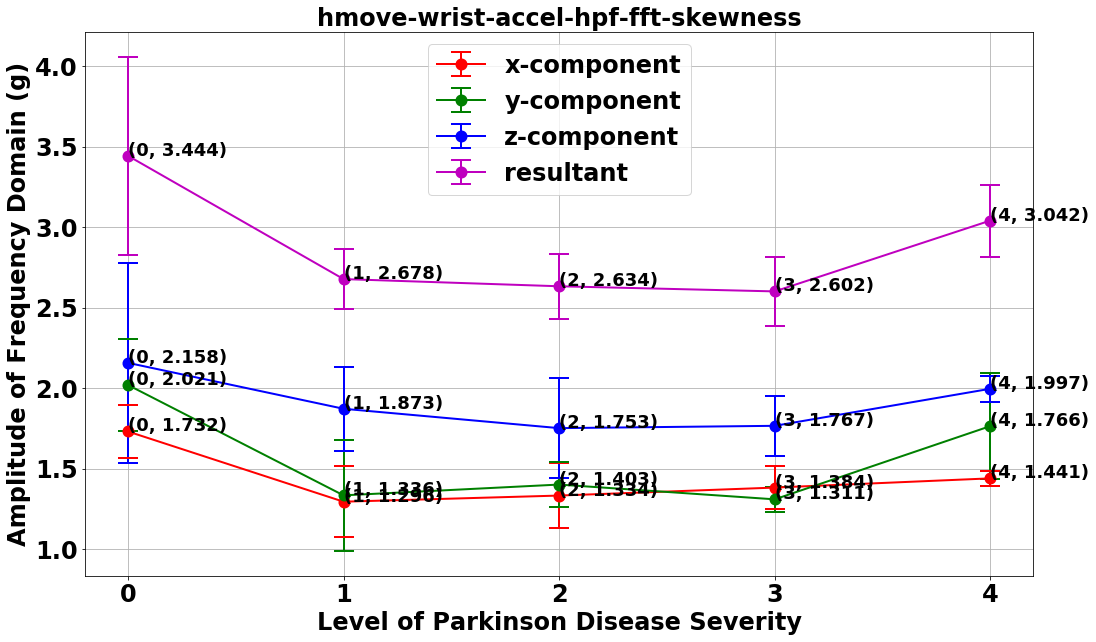

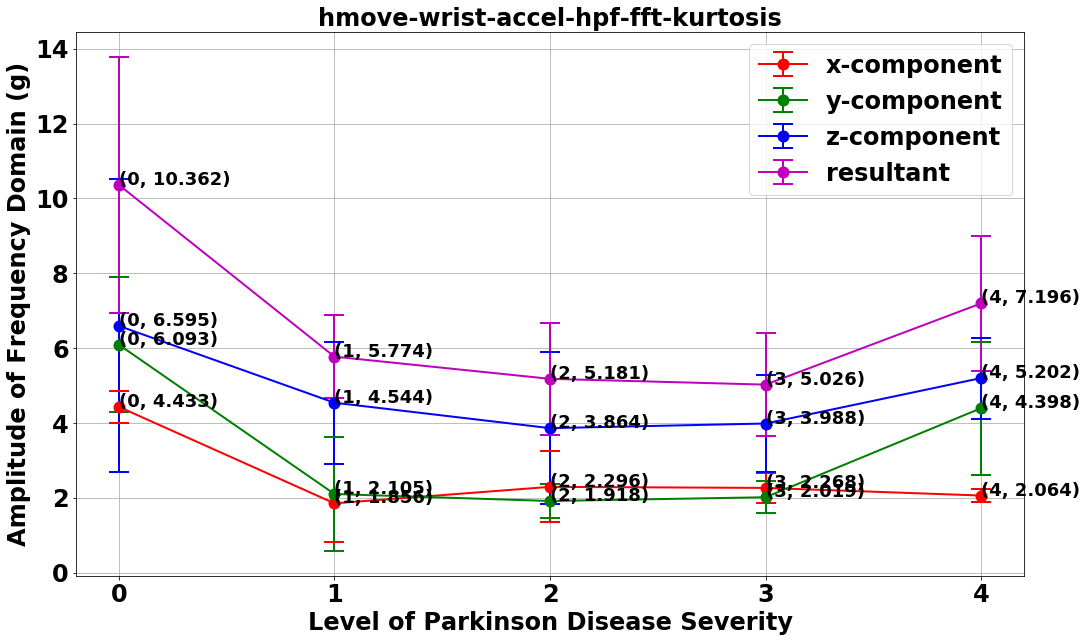

In [12]:
# ====================
# Input Parameters
# ====================
lst1 = lst_dict['hmove-wrist-accel-trial1-hpf-fft']
lst2 = lst_dict['hmove-wrist-accel-trial2-hpf-fft']
lst3 = lst_dict['hmove-wrist-accel-trial3-hpf-fft']

savefig = False
show_coordinates = True
mpld3.disable_notebook()

# ============================================================
# 5.1 Summary Statistics (mean, std, Q1, median, Q3, max)
# ============================================================
stats_lst = ['mean', 'std', '50%', 'min', 'max'] # ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
for stats_type in stats_lst: 
    stats_df_1 = process_summary_stats(database, stats_type, lst1)
    stats_df_2 = process_summary_stats(database, stats_type, lst2)
    stats_df_3 = process_summary_stats(database, stats_type, lst3)
    stats_df = process_averaged_stats(stats_df_1, stats_df_2, stats_df_3)
    plot_stats_with_error_bars(stats_df, savefig, show_coordinates)
    
# ===================================
# 5.2 Interquartile Range (Q3 - Q1)
# ===================================
iqr_stats_df_1 = process_IQR_stats(database, lst1)
iqr_stats_df_2 = process_IQR_stats(database, lst2)
iqr_stats_df_3 = process_IQR_stats(database, lst3)
iqr_stats_df = process_averaged_stats(iqr_stats_df_1, iqr_stats_df_2, iqr_stats_df_3)
plot_stats_with_error_bars(iqr_stats_df, savefig, show_coordinates)

# ========================================
# 5.3 Coefficient of Variation (mean/std)
# ========================================
cov_stats_df_1 = process_variation_stats(database, lst1)
cov_stats_df_2 = process_variation_stats(database, lst2)
cov_stats_df_3 = process_variation_stats(database, lst3)
cov_stats_df = process_averaged_stats(cov_stats_df_1, cov_stats_df_2, cov_stats_df_3)
plot_stats_with_error_bars(cov_stats_df, savefig, show_coordinates)

# =======================================
# 5.4 Skewness of Amplitude Distribution
# =======================================
skew_stats_df_1 = process_skew_stats(database, lst1)
skew_stats_df_2 = process_skew_stats(database, lst2)
skew_stats_df_3 = process_skew_stats(database, lst3)
skew_stats_df = process_averaged_stats(skew_stats_df_1, skew_stats_df_2, skew_stats_df_3)
plot_stats_with_error_bars(skew_stats_df, savefig, show_coordinates)

# =======================================
# 5.5 Kurtosis of Amplitude Distribution
# =======================================
kurt_stats_df_1 = process_kurt_stats(database, lst1)
kurt_stats_df_2 = process_kurt_stats(database, lst2)
kurt_stats_df_3 = process_kurt_stats(database, lst3)
kurt_stats_df = process_averaged_stats(kurt_stats_df_1, kurt_stats_df_2, kurt_stats_df_3)
plot_stats_with_error_bars(kurt_stats_df, savefig, show_coordinates)